# Peru: Two Years of COVID-19
A very simple analysis of the impact of COVID-19 in Peru with Pandas, Geopandas and Matplotlib in Python using Jupiter Notebooks

### How hard has COVID-19 struck a city / country / region?

One way to address this question is to take a look at the deaths, or more precisely, the excess mortality caused by the virus.

In this occassion, we desire to make a very simple analysis of the effects of COVID-19 in each "departamento" (sort of equivalent to a U.S. State) of Peru by looking at mortality levels throughout 2020-2022.

In order to do that, we are going to create **choropleth maps** with monthly deaths (adjusted by population) ocurred in a given month since 2020-01 for each "departamento", and display these maps through a .gif.

Now, for the sake of simplicity, we are going to work with total, not excess deaths, and assume that "DEPARTAMENTO DOMICILIO" stands for the place ("departamento") where a death took place. In reality, "DEPARTAMENTO DOMICILIO" accounts for the last informed "departamento" or place of residency.

We are going to work with the national deaths database of Peru, SINADEF, and the GeoJSON data of this country, available at GitHub.

You can run the notebook inside a Conda environment or create a venv and run `python -m pip install -r requirements.txt`

In [2]:
# Import dependencies
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import urllib
import subprocess
import glob
from PIL import Image
from IPython.display import display, Image 

Download dataset from this link: https://www.icloud.com/iclouddrive/0fcgC62TMY0KbcPnEaxmJ7WGw#fallecidos_sinadef and drag it to your working directory.

Read dataset and store it in "df" `dataframe`.

In [3]:
df=pd.read_csv("fallecidos_sinadef.csv",engine="python",encoding='utf-8',sep="|")

In [4]:
df.head()

,Nº,TIPO SEGURO,SEXO,EDAD,TIEMPO EDAD,ESTADO CIVIL,NIVEL DE INSTRUCCIÓN,ETNIA,COD# UBIGEO DOMICILIO,PAIS DOMICILIO,...,DEBIDO A (CAUSA B),CAUSA B (CIE-X),DEBIDO A (CAUSA C),CAUSA C (CIE-X),DEBIDO A (CAUSA D),CAUSA D (CIE-X),DEBIDO A (CAUSA E),CAUSA E (CIE-X),DEBIDO A (CAUSA F),CAUSA F (CIE-X)
0,1,IGNORADO,FEMENINO,64,AÑOS,SOLTERO,IGNORADO,MESTIZO,92-33-24-01-01-000,PERU,...,INFARTO RECIENTE Y ANTIGUO DE MIOCARDIO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,SIS,FEMENINO,15,MINUTOS,SOLTERO,SUPERIOR NO UNIV. COMP.,MESTIZO,92-33-12-08-06-000,PERU,...,DIFICULTAD RESPIRATORIA DEL RECIEN NACIDO,P229,INMATURIDAD EXTREMA,P072,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
2,3,ESSALUD,MASCULINO,97,AÑOS,CASADO,PRIMARIA INCOMPLETA,MESTIZO,92-33-04-01-23-000,PERU,...,ENFERMEDAD RENAL,N189,ENFERMEDAD PULMONAR INTERSTICIAL DIFUSA,J849,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
3,4,IGNORADO,MASCULINO,31,AÑOS,SOLTERO,IGNORADO,MESTIZO,92-33-07-06-01-000,PERU,...,EDEMA PULMONAR,J81X,EN INVESTIGACION,R99X,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
4,5,IGNORADO,MASCULINO,59,AÑOS,SOLTERO,IGNORADO,MESTIZO,92-33-24-01-01-000,PERU,...,SHOCK HIPOVOLEMICO,SIN REGISTRO,SUCESO DE TRANSITO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO


In [5]:
print(df.shape)
print(df.columns)

(846732, 32)
Index(['Nº', 'TIPO SEGURO', 'SEXO', 'EDAD', 'TIEMPO EDAD', 'ESTADO CIVIL',
       'NIVEL DE INSTRUCCIÓN', 'ETNIA', 'COD# UBIGEO DOMICILIO',
       'PAIS DOMICILIO', 'DEPARTAMENTO DOMICILIO', 'PROVINCIA DOMICILIO',
       'DISTRITO DOMICILIO', 'FECHA', 'AÑO', 'MES', 'TIPO LUGAR',
       'INSTITUCION', 'MUERTE VIOLENTA', 'NECROPSIA', 'DEBIDO A (CAUSA A)',
       'CAUSA A (CIE-X)', 'DEBIDO A (CAUSA B)', 'CAUSA B (CIE-X)',
       'DEBIDO A (CAUSA C)', 'CAUSA C (CIE-X)', 'DEBIDO A (CAUSA D)',
       'CAUSA D (CIE-X)', 'DEBIDO A (CAUSA E)', 'CAUSA E (CIE-X)',
       'DEBIDO A (CAUSA F)', 'CAUSA F (CIE-X)'],
      dtype='object')


- We are interested in "FECHA" `string column` and "DEPARTAMENTO DOMICILIO" `string column`. In other words, when and where a death took place. 
- We also want to order this dataset by date, from older to newer, so we create a new column "DATE" `datetime column` based on "FECHA" `string column` and apply the `sort_values` method.
- Inspecting "FECHA" `string column` we realise that it goes back to 2017 and up to frebrueary 2022. Since covid-19 pandemic struck Peru in March 2020, we filter the dataset on "AÑO" `int column` >= 2020.
- Since "DEPARTAMENTO DOMICILIO" `string column` includes places outside of Peru, we filter the dataset on "PAIS DOMICILIO" `string column` == "PERU".
- There is an empty string in "DEPARTAMENTO DOMICILIO" `string column` representing the unknown, so we get rid of it by applying yet another filter.
- Now that our dataset is ordered by date, we create a new column "MES-AÑO" `string column` based of the year and month of "FECHA" `string column`, as in, 2020-01, 2020-02, and so on.
- Finally, we create a subset of our dataset with only three columns: "DEPARTAMENTO DOMICILIO" `string column`, "MES-AÑO" `string column` and "SEXO" `string column`. We could have picked any other column instead of "SEXO" as long as it holds one entry per row, which most columns do. This is beceause we are going to group our dataset by "MES-AÑO" `string column` and **count** occurrences of the third column (deaths).

In [6]:
df['DATE'] = df['FECHA'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df = df.sort_values(by=['DATE'], ascending=True)
df=df[(df["PAIS DOMICILIO"]=="PERU") & (df["AÑO"].isin([2020,2021,2022]))]
df["DEPARTAMENTO DOMICILIO"] = df["DEPARTAMENTO DOMICILIO"].map(str.strip)
df=df[df["DEPARTAMENTO DOMICILIO"]!=""]
df["MES-AÑO"]=df["FECHA"].apply(lambda x: x[:5])+df["FECHA"].apply(lambda x: x[5:7])
df=df[['DEPARTAMENTO DOMICILIO',"MES-AÑO","SEXO"]]

Now that we have a more concise dataset, we can apply two `for loop`s in order to obtain a list of dicts, where each dict represents a "departamento" ("DEPARTAMENTO DOMICILIO" `string column`) and is going to be comprised of "date", "deaths" key-value pairs.

In [7]:
result=[]
max=0
for dep in df["DEPARTAMENTO DOMICILIO"].unique():
  data={}
  sdf=df[df["DEPARTAMENTO DOMICILIO"]==dep]
  sdf=sdf.groupby(sdf['MES-AÑO']).count().reset_index()
  for date in df['MES-AÑO'].unique():
    try:
      data[date]=sdf[sdf["MES-AÑO"]==date]["SEXO"].values[0]
    except IndexError:
      data[date]=0
    if data[date]>max:
      max=data[date]
  result.append(data)

Now that we have a list of dicts, we can easily convert it into a pandas dataframe object and store it in "final_df" `dataframe`, setting each "departamento" as an index. Then, we sort this brand new dataframe by its index in alphabetical order so we can match it with the new dataset (GeoJSON) that we are going to import afterwards.

In [8]:
final_df=pd.DataFrame(result,index=df["DEPARTAMENTO DOMICILIO"].unique()) 
final_df.sort_index(inplace=True)

If we inspect this newly created dataset, we can appreciate that it contains 25 "departamento"s (places where deaths occurred) and 27 "MES-AÑO" (months).

In [9]:
final_df.shape

(25, 27)

- A proper comparison of deaths in each "departamento" shall take into account how many people live in such "departamento". So, in the end, we are going to measure deaths adjusted by population.
- In order to do that we need the population of each "departamento", data that can be retrieved directly from [here](https://es.wikipedia.org/wiki/Anexo:Departamentos_del_Perú_por_población).
- This wikipedia dataset can be read directly with pandas `read_html` method but, first, we need to parse the last part of the url for it contains accents.
- Then, we store that population dataset in "pop_df" `dataframe`.

In [10]:
base_url="https://es.wikipedia.org/wiki/"
query='Anexo:Departamentos_del_Perú_por_población'
query=urllib.parse.quote(query)
url=base_url+query
url
pop_df=pd.read_html(url)[0]

In [11]:
pop_df

Ubigeo        Departamento           Capital Superficie(km²)  Población  \
   Ubigeo        Departamento           Capital Superficie(km²) Censo 2017   
0       1            Amazonas       Chachapoyas       39 249,13    379 384   
1       2              Áncash            Huaraz       35 914,81  1 083 519   
2       3            Apurímac           Abancay       20 895,79    405 759   
3       4            Arequipa          Arequipa       63 345,39  1 382 730   
4       5            Ayacucho          Ayacucho       43 814,80    616 176   
5       6           Cajamarca         Cajamarca       33 317,54  1 341 012   
6       7          Callao[4]​            Callao           14698    994 494   
7       8               Cusco             Cusco       71 986,50  1 205 527   
8       9        Huancavelica      Huancavelica       22 131,47    347 639   
9      10             Huánuco           Huánuco       36 848,85    721 047   
10     11                 Ica               Ica       21 327,83    850 765   
11     12               Junín          Huancayo       44 197,23  1 246 038   
12     13         La Libertad          Trujillo        25 499,9  1 778 080   
13     14          Lambayeque          Chiclayo        14 231,3  1 197 260   
14     15  Lima Metropolitana              Lima          267228  9 612 705   
15     16                Lima            Huacho       34 801,59    910 431   
16     17              Loreto           Iquitos      368 851,95    883 510   
17     18       Madre de Dios  Puerto Maldonado       85 300,54    141 070   
18     19            Moquegua          Moquegua       15 733,97    174 863   
19     20               Pasco    Cerro de Pasco       25 319,59    254 065   
20     21               Piura             Piura       35 892,49  1 856 809   
21     22                Puno              Puno       71 999,00  1 172 697   
22     23          San Martín         Moyobamba       51 253,31    813 381   
23     24               Tacna             Tacna       16 075,89    329 332   
24     25              Tumbes            Tumbes          466920    224 863   
25     26             Ucayali          Pucallpa      102 410,55    496 459   

                 Densidad2017 (hab/km²) Ubicación  
   Estimado 2020 Densidad2017 (hab/km²) Ubicación  
0        426 806                   9.66       NaN  
1      1 180 638                  30.17       NaN  
2        430 736                  19.42       NaN  
3      1 497 438                  21.83       NaN  
4        668 213                  14.06       NaN  
5      1 453 711                  40.25       NaN  
6      1 129 854                6766.19       NaN  
7      1 357 075                  16.75       NaN  
8        365 317                  15.71       NaN  
9        760 267                  19.57       NaN  
10       975 182                  39.89       NaN  
11     1 361 467                  28.19       NaN  
12     2 016 771                  69.73       NaN  
13     1 310 785                  69.73       NaN  
14     9 674 755                3208.86       NaN  
15     1 015 765                 272.56       NaN  
16     1 027 559                   2.40       NaN  
17       173 811                   1.65       NaN  
18       192 740                  11.11       NaN  
19       271 904                  10.03       NaN  
20     2 047 954                  51.73       NaN  
21     1 237 997                  16.28       NaN  
22       899 648                  15.87       NaN  
23       370 974                  20.49       NaN  
24       251 521                  48.16       NaN  
25       589 110                   4.85       NaN

Now, upon closer inspection, we notice that there are 26 "departamento"s and not 25. This is because the city of Lima, "Lima Metropolitana" was considered as an independent entity in the aformentioned wikipedia table due to its relevance.

However, we want Lima as a whole. In other words, sum the populations of "Lima Metropolitana" (city) and "Lima" (rest of the cities that are part of Lima "departamento"). We can deal with such problem as follows:

- First, we retrieve "Población" (population) column (estimates for 2020) and store it in pop_array `array`.
- Second, "Lima Metropolitana" and "Lima" are represented by indexes 14 and 15 respectively, so, in pop_array `array`, we add the value at index 15 to the value at index 14 and drop the value at index 15.

Now, pop_array `array` contains the population of each "departamento" in alphabetical order, which is going to match with our main dataframe, final_df, and the GeoJSON dataset that we are going to import in a few moments.

In [12]:
pop_array=pop_df[("Población","Estimado 2020")].apply(lambda x: int(x.replace("\xa0",""))).values
pop_array[14]=pop_array[14]+pop_array[15]
pop_array=np.delete(pop_array,15)

Then, we divide each column in "final_df" `dataframe` by "pop_array" `array`, multiply the result by 1000000 and replace "final_df"'s values. In other words, we go from "deaths" to "deaths per by million habitants".

In [13]:

for date in final_df.columns:
  final_df[date]=(final_df[date]/pop_array)*np.full([len(pop_array)],1000000)

Now, we proceed to import the GeoJSON data for every "departamento" of Peru and store it in "df_peru" `dataframe`.

In [14]:
df_peru = gpd.read_file('https://raw.githubusercontent.com/juaneladio/peru-geojson/master/peru_departamental_simple.geojson')
df_peru.head()

,NOMBDEP,COUNT,FIRST_IDDP,HECTARES,geometry
0,AMAZONAS,84,01,3930646.567,"POLYGON ((-77.75893 -6.96451, -77.84586 -6.976..."
1,ANCASH,166,02,3596224.600,"POLYGON ((-77.31749 -8.53015, -77.28903 -8.589..."
2,APURIMAC,80,03,2111415.170,"POLYGON ((-72.47177 -14.66140, -72.57725 -14.6..."
3,AREQUIPA,109,04,6325588.935,"POLYGON ((-75.07333 -15.44294, -75.04965 -15.4..."
4,AYACUCHO,111,05,4350381.783,"POLYGON ((-74.34595 -12.17374, -74.32187 -12.2..."


Then, we create a new column "coords" which is going to be used to porperly label each "departamento" with its name on the map. 

In [15]:
df_peru['coords'] = df_peru['geometry'].apply(lambda x: x.representative_point().coords[:])
df_peru['coords'] = [coords[0] for coords in df_peru['coords']]

Having finshed the data manipulation part, we can move onto plotting our choropleth maps.

- First, we set vmin and vmax variables to store the min and max global amount of deaths.
> If you don’t set this beforehand, Matplotlib will change the range of the choropleth each time the for loop iterates, so it will be harder to see how values have increased or decreased over time.
- Then, we create a `for loop` that, for each month, appends to df_peru `dataframe` (GeoJSON data) the column corresponding to that month of final_df `dataframe`, plots the choropleth map and then removes that column back so as not to increase the size of df_peru `dataframe` in each loop.
- Also, in each loop, we store the plotted map inside the just created "img" directory with padding zeros to keep a proper order.
- Additionally, we store the map corresponding to the worst month of the pandemic inside the "worst_month_map" variable in order to call it afterwards.

This whole process will create a total of 27 choropleth maps (one per month) inside "img" directory .


In [16]:
# Plot function
def plot(month,i,vmin,vmax,dep=None):
  references='References: SINADEF, INEI, Wikipedia, @juaneladio (GitHug user)'
  df_peru[month]=final_df[month].values
  fig, ax = plt.subplots(1, figsize=(13, 15))
  if dep is None:
    df_peru_to_plot=df_peru
    description="Deaths per 'departamento', adjusted by population"
  else:
    df_peru_to_plot=df_peru[df_peru["NOMBDEP"]==dep]
    description=f"Deaths in {dep} adjusted by population"
  df_peru_to_plot.plot(column=month,cmap='cool',
  linewidth=1, ax=ax,edgecolor='1', vmin=vmin, vmax=vmax,legend=True,
  norm=plt.Normalize(vmin=vmin, vmax=vmax))
  ax.axis("off")
  ax.set_title(f"{month}",fontsize=30)
  ax.set_title(f"{month}",fontsize=30, weight='bold')
  for idx, row in df_peru.iterrows():
    ax.text(row.coords[0], row.coords[1], row["NOMBDEP"], 
    horizontalalignment='center', 
    bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})
  ax.annotate(description, xy=(0.15, .95), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='bottom',
            fontsize=25)
  ax.annotate(references, xy=(0.62, 0.1), xycoords='figure fraction',
            horizontalalignment='right', verticalalignment='top',
            fontsize=15, style='italic')
  ax.annotate("Deaths per million habitants", xy=(0.93, 0.91), xycoords='figure fraction',
            horizontalalignment='right', verticalalignment='top',
            fontsize=18, style='italic')
  if i<10:
    filepath = f"img/00{i}.jpg"
  else:
    filepath = f"img/0{i}.jpg"

  chart = ax.get_figure()
  chart.savefig(filepath, dpi=200)
  plt.close()
  df_peru.drop(columns=month, inplace=True)
  return filepath

In [17]:
# Calls plot function for each month
if not os.path.exists("img"):
  os.mkdir("img")
vmin, vmax=0,final_df.max().max()
df.columns
i=1
for month in final_df.columns.values:
  filepath=plot(month,i,vmin,vmax)
  print(f"{i} of {len(final_df.columns)} processed")
  i+=1
  if final_df.sum().idxmax()==month:
    worst_month_chart_path=filepath

1 of 27 processed
2 of 27 processed
3 of 27 processed
4 of 27 processed
5 of 27 processed
6 of 27 processed
7 of 27 processed
8 of 27 processed
9 of 27 processed
10 of 27 processed
11 of 27 processed
12 of 27 processed
13 of 27 processed
14 of 27 processed
15 of 27 processed
16 of 27 processed
17 of 27 processed
18 of 27 processed
19 of 27 processed
20 of 27 processed
21 of 27 processed
22 of 27 processed
23 of 27 processed
24 of 27 processed
25 of 27 processed
26 of 27 processed
27 of 27 processed


Last but not least, we make a .gif out of those 27 maps and, if preferred, erase them to save disk space.

Please note that in order to perform this action, you must install ImageMagick, as in `brew install imagemagick` (MacOS).

In [19]:
back=os.getcwd()
os.chdir("img")
subprocess.call([
  "convert", "-delay", "90", "-loop", "0", "*.jpg","output.gif"
])
# Deletes every image except for 016.jpg
for file_name in glob.glob("*.jpg"):
  if file_name != os.path.basename(worst_month_chart_path):
    os.remove(file_name)
# ========================================
os.chdir(back)

Optionally, we can also create a .mp4 video instead of a .gif.

Please note that in order to perform this action, you must install FFmpeg, as in `brew install ffmpeg` (MacOS).

In [ ]:
# back=os.getcwd()
# os.chdir("img")
# subprocess.call([
#     'ffmpeg', '-framerate', '24', '-i','%03d.jpg', '-r', '30',"-crf", "0", "-vcodec", "mpeg4", "-vf", "setpts=10*PTS",
#     'output.mp4'
# ])
# # Deletes every image except for 016.jpg
# for file_name in glob.glob("*.jpg"):
#   if file_name != os.path.basename(worst_month_chart_path):
#     os.remove(file_name)
# # ========================================
# os.chdir(back)

#### *Since GitHub can't render .gif inside Jupyter Notebooks, we can take a look at the final result in our "img" directory. This "output.gif" file is the one displayed at README.md.*

This .gif file allows us to appreciate the evolution of the mortality of COVID-19 in each "departamento" of peru throughout these past two years, as of March 2022.

Just before stating our conclusions, let's retrieve some additional and useful data.

1. Ten hardest-hitted "departamento"s by COVID-19 in a single month, deaths per million habitants.
"MOQUEGUA" takes first place.

In [20]:
final_df.max(axis=1).sort_values(ascending=False)[:10] 

MOQUEGUA    2345.128152
AREQUIPA    1777.035176
TACNA       1533.800212
UCAYALI     1529.425744
LIMA        1479.535140
ANCASH      1469.544433
PIURA       1452.669347
PUNO        1432.152097
LORETO      1374.130342
TUMBES      1339.848363
dtype: float64

2. August 2020 is the month where "MOQUEGUA" reached its mortality peak, with over 2300 deaths per million habitants

In [21]:
final_df.index.get_loc("MOQUEGUA")
final_df.iloc[17].idxmax()

'2020-08'

3. Plot "MOQUEGUA" at 2020-08, save the map as 030.jpg inside "img" directory and display it

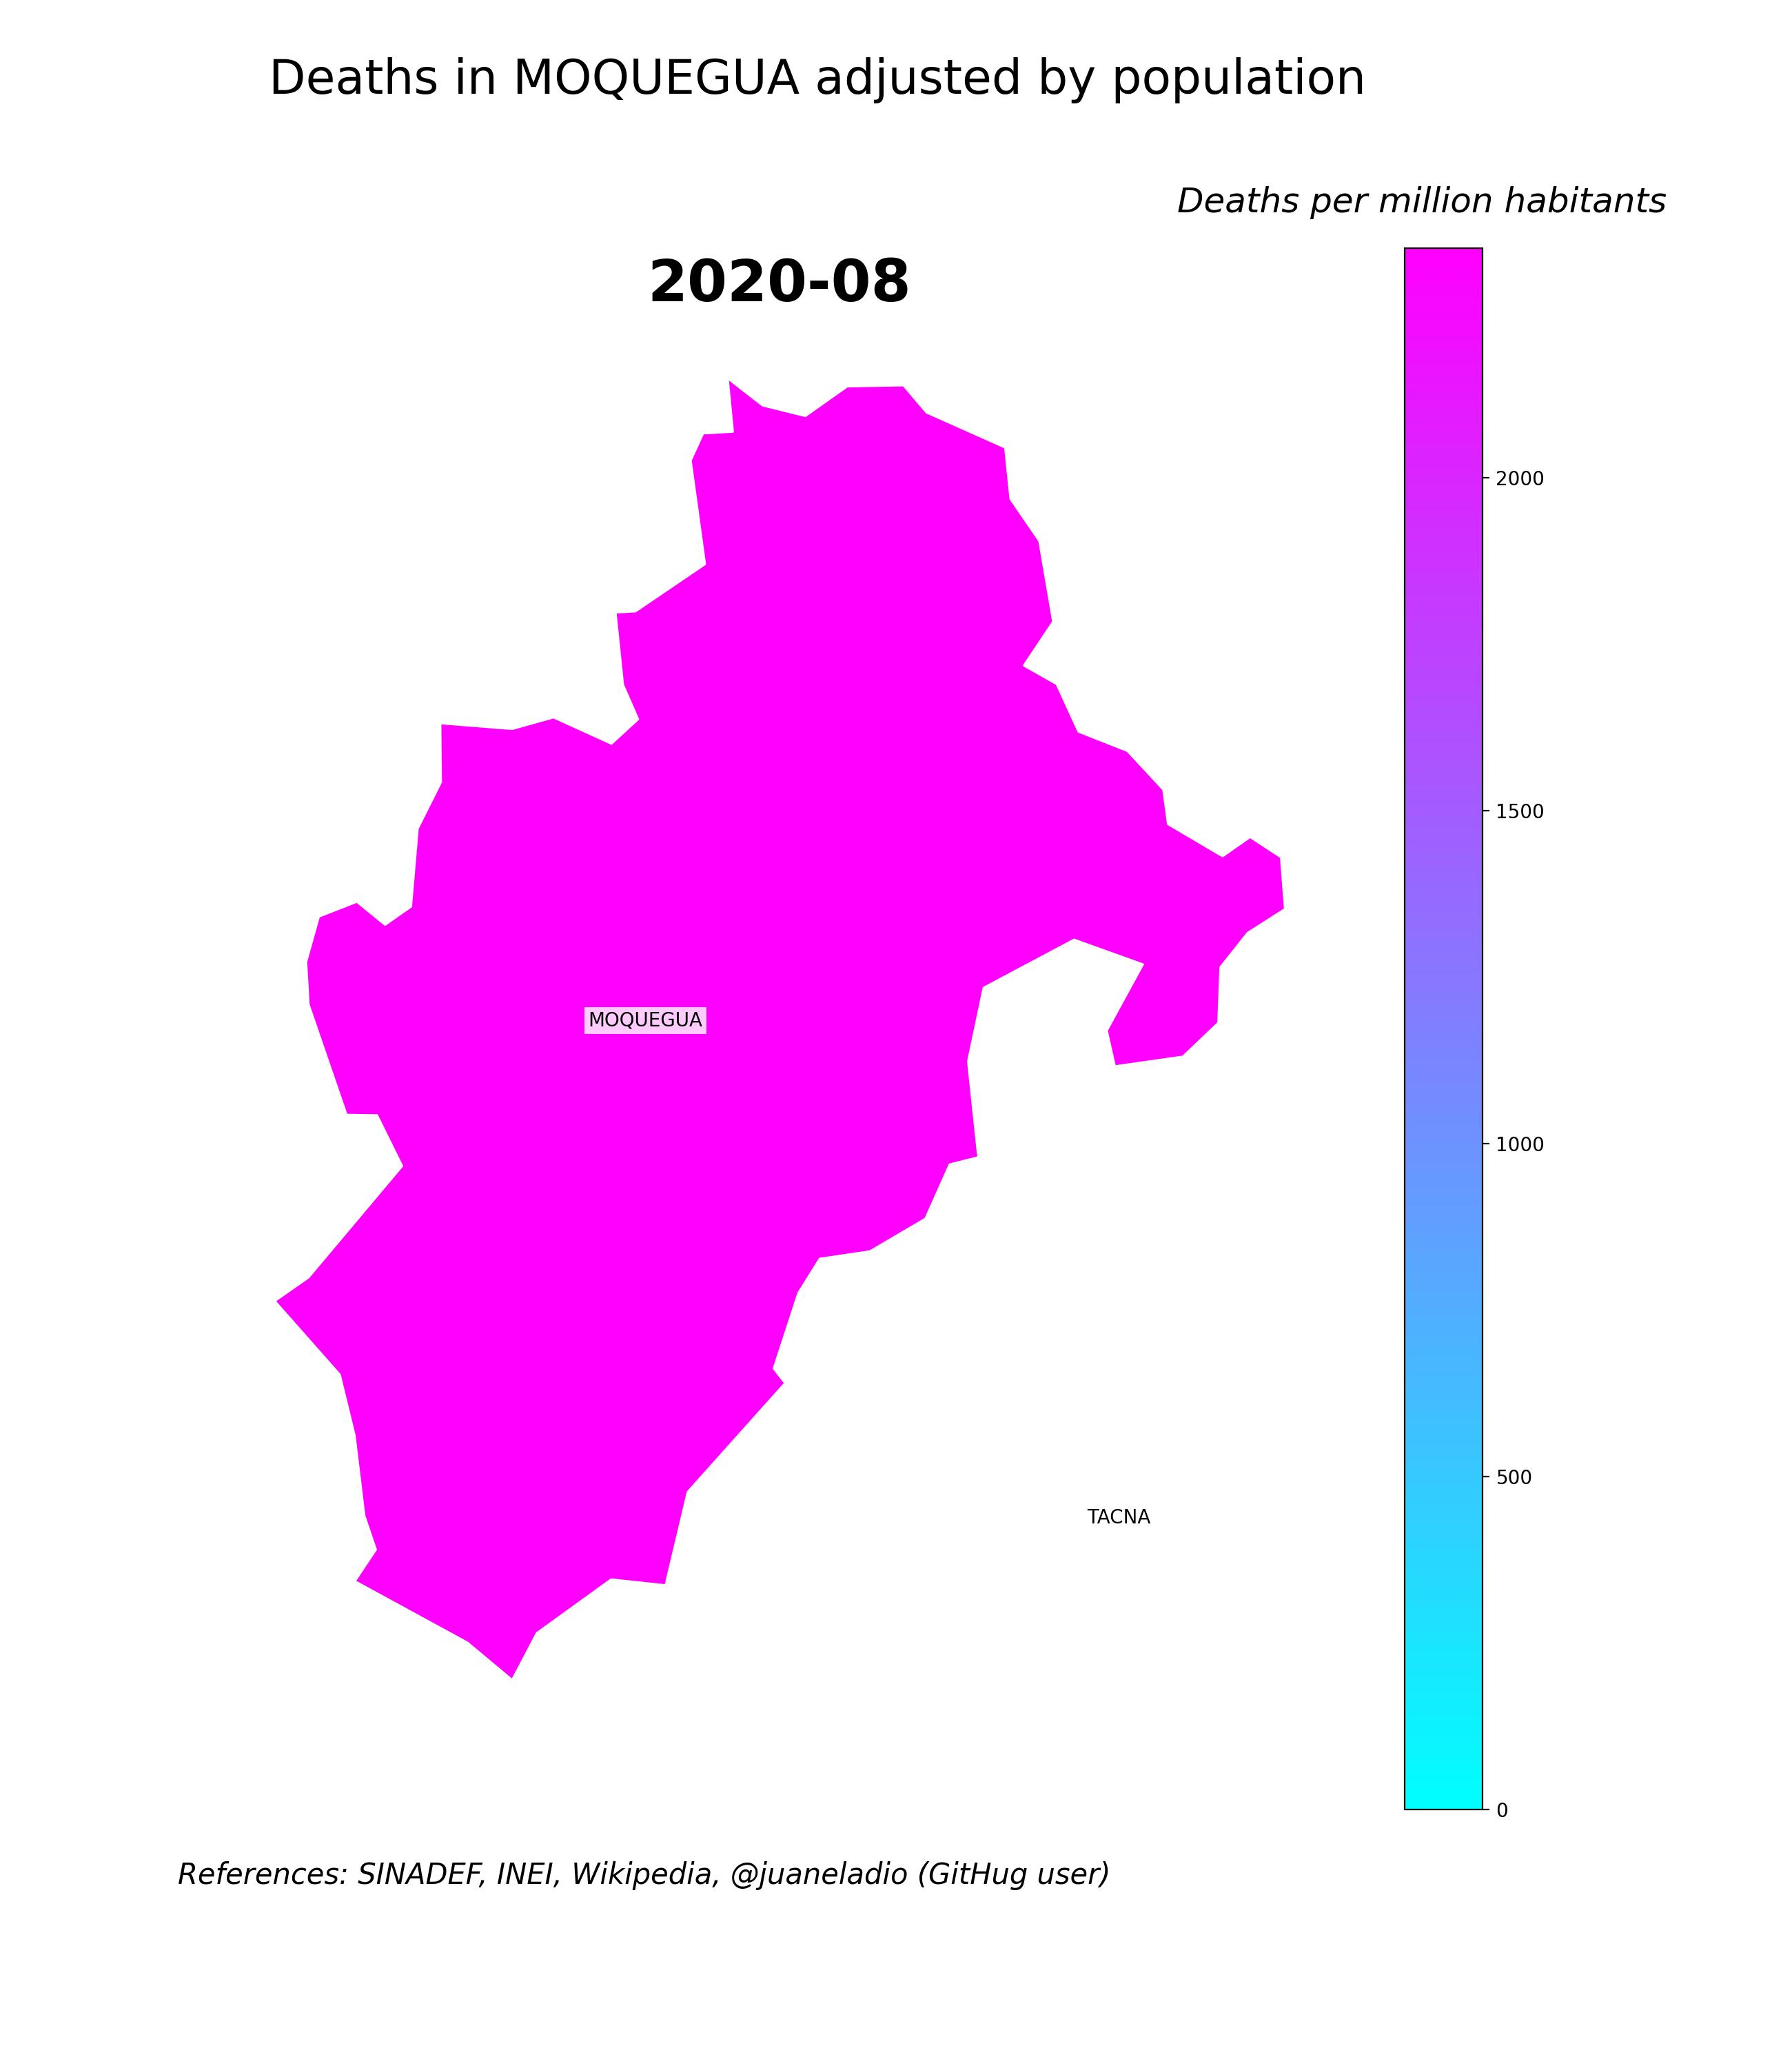

In [22]:
chart=plot("2020-08",30,vmin,vmax,"MOQUEGUA")
pil_img = Image(filename='img/030.jpg')
display(pil_img)

4. Get the worst month of the COVID-19 pandemic

In [23]:
final_df.sum().idxmax()

'2021-04'

5. Get the Ten hardest-hitted "departamento"s by COVID-19, historically since 2020.

In [24]:
final_df.sum(axis=1).sort_values(ascending=False)[:10].index

Index(['LIMA', 'ICA', 'AREQUIPA', 'ANCASH', 'HUANCAVELICA', 'MOQUEGUA', 'PUNO',
       'TUMBES', 'JUNIN', 'LA LIBERTAD'],
      dtype='object')

6. Get worst month of the pandemic, plot, save and display it

2021-04


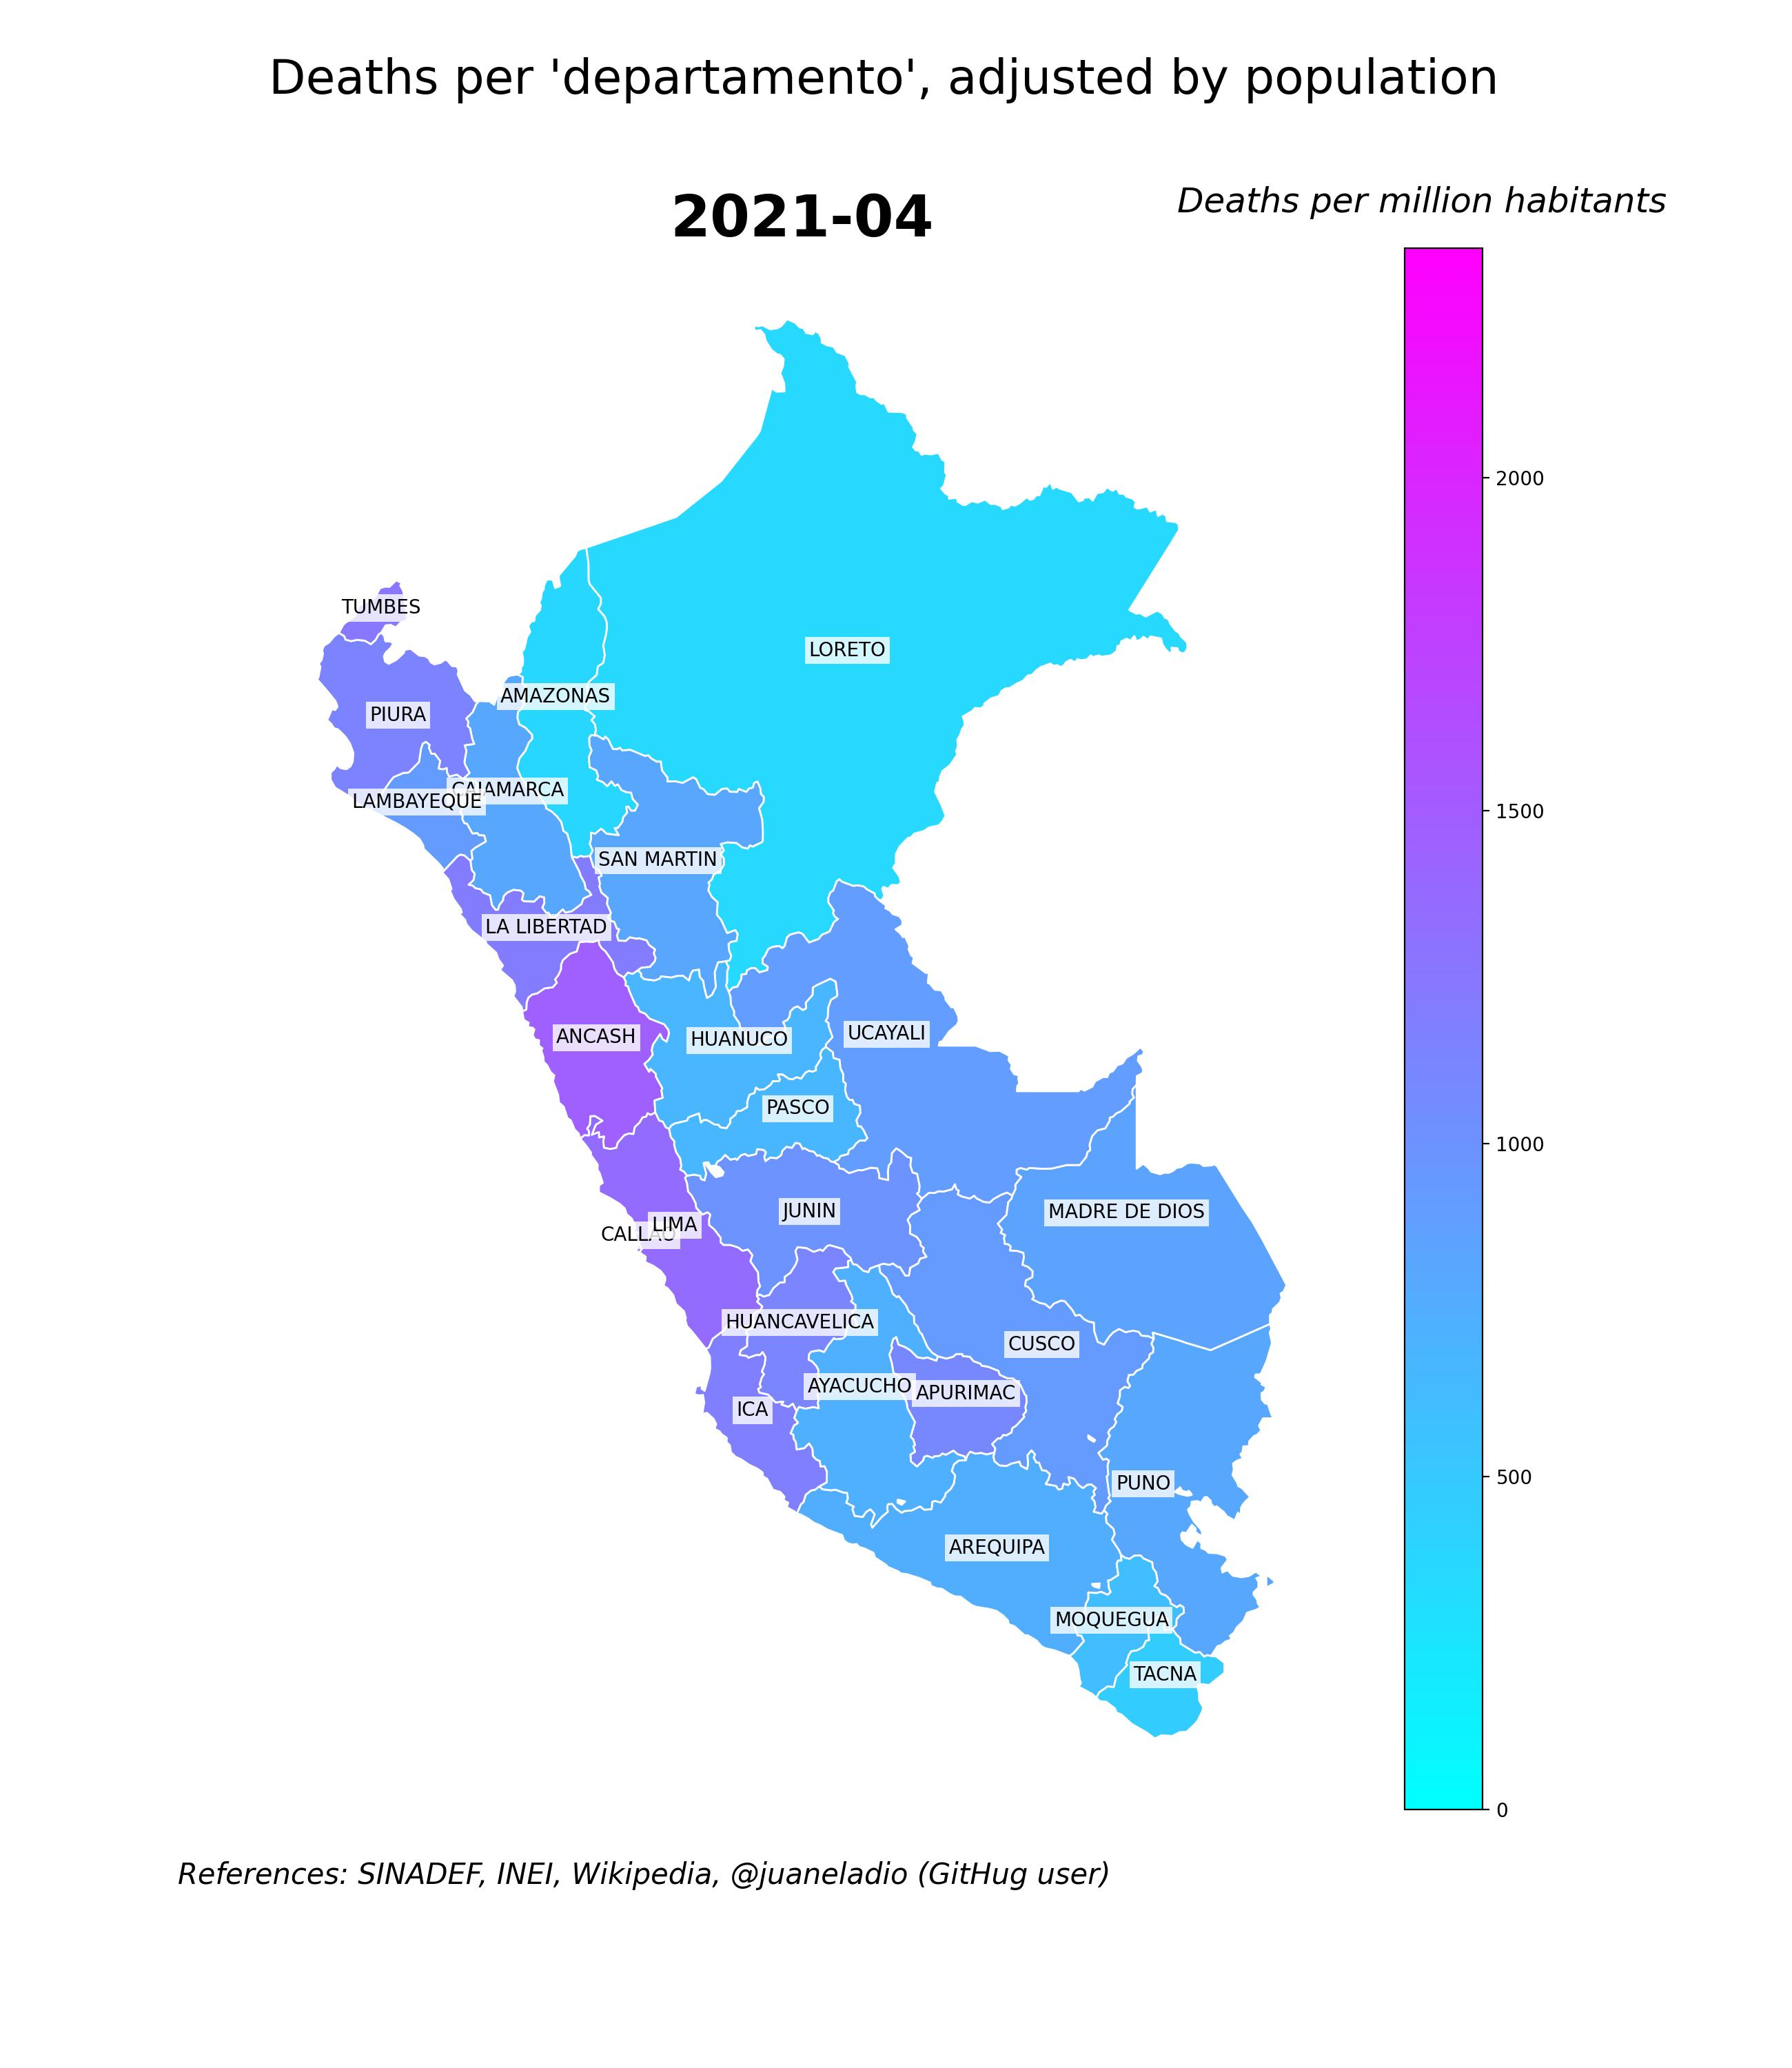

In [25]:
print(final_df.sum().idxmax())
pil_img = Image(filename=worst_month_chart_path)
display(pil_img)

### Conclusions

- Now that we have displayed our **choropleth maps** in animated fashion, we can appreciate that the mortality level started to surge in april 2020 and receded in september 2020, which is now known as the "first wave".

- Then, in december 2020, our maps start to get "more vivid" once again, representing the "second wave", which was the deadliest and lasted till July of 2021, comprising the deadlist month since COVID-19 arrived in Peru, April 2021.

- Eventually, in January and February of 2022 we can see the map going bluer, representing a third but **MUCH less deathly and shorter** wave (god bless vaccines and the people behind this humankind achievement).

- We can also appreciate that, at the worst moment of the pandemic, monthly deaths surpassed the milestone of 2000 per million habitants.

- Now, even though we have been working with total deaths and not excess mortality, we can easily notice that a "normal" death rate for any given "departamento" of Peru sits somewhere around 500 per million habitants at any given month. This detail, however, does not seem to distort our conclusions.

- As a matter of fact, we could infere that our deaths per million habitants **minus** a number around 500 ("normal" death rate per million habitants) is a pretty decent and **particularily intuitive** approach to the excess mortality ratio, which is to say, the deaths that can actually be attributed to COVID-19 (per million habitants). 

- Also, "MOQUEGUA" was the hardest-hitted "departamento" in a given month, reaching over 2300 deaths per million habitants in August 2020. Nonetheless, overall, "LIMA", "ICA" and "AREQUIPA" are the ones that accounted for the highest dead tolls per million habitants during these two years of COVID-19 in Peru.

- Now, why things went so badly for Peru when it was one the first countries to apply stricts and lenghtly lockdowns is beyond the scope of this short analysis. However, one may find some clues in the **almost complete absence** of two key policies: **contact tracing** and **rigurous testing**.

- On an end note, our findings match what actually happened in real life, as it was reported by health authorities and public media:
  - There have been three ways of COVID-19 in Peru so far.
  - These waves ocurred exactly as shown in our .gif.
  - The second wave was the deadliest.
  - The third wave was short-lived.
  - Things went way out of hand for Peru as a whole, but "LIMA", "ICA" and "AREQUIPA" certainly took the heaviest hit.

*Thanks*

### References:

- https://towardsdatascience.com/how-to-make-a-gif-map-using-python-geopandas-and-matplotlib-cd8827cefbc8
- https://stackoverflow.com/questions/38899190/geopandas-label-polygons
- https://stackoverflow.com/questions/26649716/how-to-show-pil-image-in-ipython-notebook